In [139]:
#Functionalized Data to CC Midi Data - Arbitrary Set Time

import matplotlib.pyplot as plt
import numpy as np
import random as rand

from midiutil import MIDIFile

%matplotlib inline


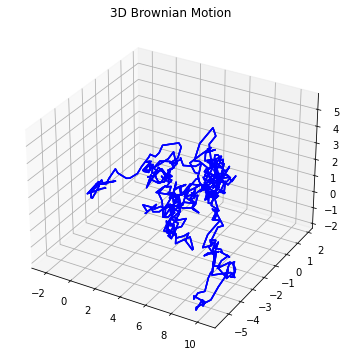

In [140]:
#Making some fancy data part 2.0

from pylab import show
from math import sqrt
from scipy.stats import norm
from mpl_toolkits.mplot3d.axes3d import Axes3D

def brownian(x0, n, dt, delta, out=None):

   #  n : The number of steps to take.
   #  dt : time step
   #  delta : "speed" of motion
   #  out :If `out` is NOT None, it specifies the array in which to put the
   #      result.  If `out` is None, a new numpy array is created and returned.
    x0 = np.asarray(x0) #I.C
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt)) #generate n numbers for sample
    
    if out is None: #create out array
        out = np.empty(r.shape)
        
    np.cumsum(r, axis=-1, out=out) #cumulative sum for random variables
    out += np.expand_dims(x0, axis=-1) #initial condition.
    
    return out

fig = plt.figure(1, figsize=(8,6)) #prepare plot
ax = fig.add_subplot(projection='3d')
    
delta = 2 # The Wiener process parameter.
T = 10.0
N = 500# Number of steps.
dt = T/N
m = 3 # Number of "lines"

x = np.empty((m,N+1))# Create an empty array to store the realizations.
x[:, 0]= 0# Initial values of x.

brownian(x[:,0], N, dt, delta, out=x[:,1:]) 

t = np.linspace(0.0, T, N+1)

for i in range(m):
    xdata, ydata, zdata = x[:3,:]
    ax.plot3D(xdata, ydata, zdata, color='b')
    ax.set_title('3D Brownian Motion')

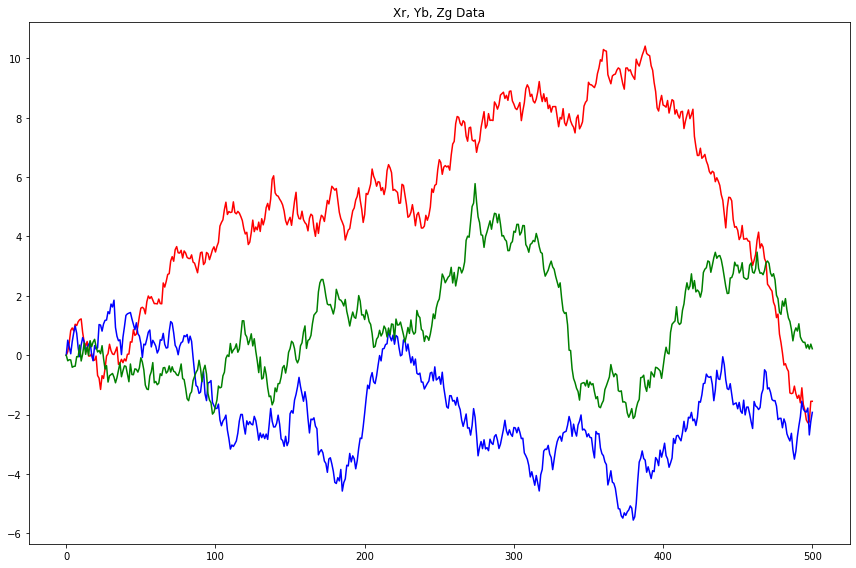

In [141]:
#Look at individual plots!

fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(xdata, 'r')
ax.set_title('Xr, Yb, Zg Data')

ax.plot(ydata, 'b')
ax.plot(zdata, 'g')

plt.tight_layout()


Length of Data: 501
[[ 0.          0.          0.        ]
 [ 0.11927734  0.50759949 -0.18751629]
 [ 0.42271507  0.27619074 -0.15069494]
 [ 0.83387308  0.04930128 -0.15889988]
 [ 0.92021668  0.45499634 -0.40546181]]
... ...
[-1.55145594 -1.92492037  0.21807811]

step size:  1
New Data Length: 501
[[44.17423886 44.17423886 44.17423886]
 [45.12294691 48.21158348 42.68277184]
 [47.53642987 46.37100465 42.97564149]]


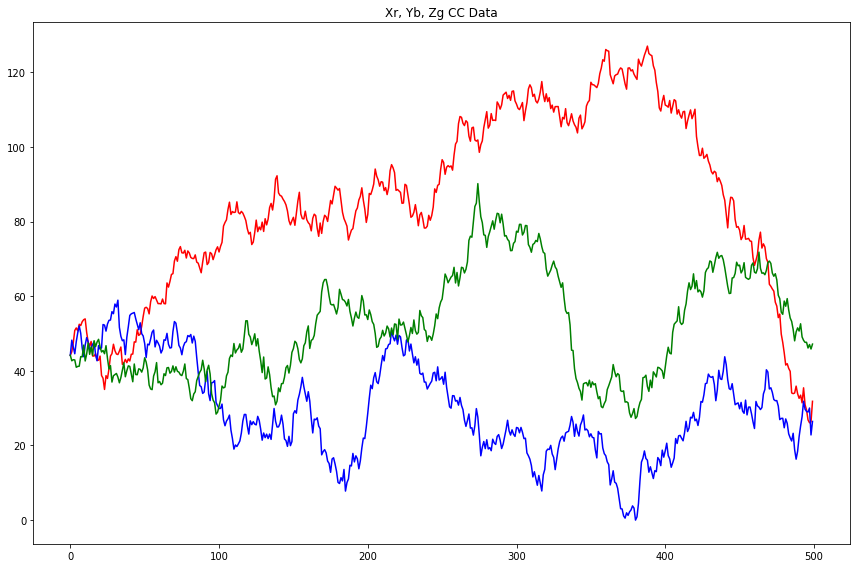

In [146]:
#Similiar to notes we decide a sample rate. This can be much higher than when choosing
# notes, CC data maps without transients so it gets interpolated at the DAW level

#Aggregating Data Lists into a single Array for Ease of Use

data = np.column_stack([xdata, ydata, zdata])
print('Length of Data:', len(data))
print(data[0:5])
print('... ...')
print(data[500])

#Decide on sample amount from Data (or range)
target_n = 501 #CHANGE THIS
step = int(len(data)/target_n)
print('\nstep size: ', step)

data = data[0::step]
print('New Data Length:', len(data))

midicc_range = np.linspace(0, 127, 128) #CC Data ranges from 0 to 127

nout = np.interp(data, (data.min(), data.max()), (0, len(midicc_range)-1))

print(nout[0:3])

#convoluted PLotting because of the Column Stack. Consider using VStack
fig, ax = plt.subplots(1, figsize=(12,8))
colors = ['r', 'b', 'g']
for j in range(0, m): #m = number of lines
    plot_data = []  

    for i in range(0, len(nout)-1):
        plot_data.append(nout[i][j])
        
    ax.plot(plot_data, colors[j])

ax.set_title('Xr, Yb, Zg CC Data')
plt.tight_layout()

In [161]:
#What we just did as a function
# Notice we don't need to round things this time. Cc can take a floating point

def Map_Data_to_CC(data, target_n):
    
    cc = np.linspace(0,127,128)
    
    step = int(len(data)/target_n)
    data = data[0::step]
    nout = np.interp(data, (data.min(), data.max()), (0, len(cc)-1))
    out = np.zeros((2, len(nout))) #Set official out array, data:midi
    
    for i in range(len(nout)):
        s = int(np.round(nout[i]))
        out[0,i] = data[i]
        out[1,i] = s
    
    return out

In [162]:
#Get Bpm and Score Duration

bpm = 140 #140 beats per minute

print('BeatsPerMin: ', bpm)
bps = bpm/60.
print('BeatsPerSec: ', bps)
spb = 1/bps
print('SecondsPerBeat:', spb)
print('Length of 1 Bar: ', spb*4)

#ticks = 960, one tick = one quarternote

tscore_target = 120 #2 minute target time for score, seconds
tick = 960 #A constant, one tick = one quarternote, 960 tpqn

# Approximate Points Needed
div = 120 / len(data)
print('\nseconds per data point needed:', div)

# Figure out how many Ticks you need for given Bpm
ticks_perdiv = (960*div)/spb
print('IMPORTANT: Ticks (960pqn) per data point:', ticks_perdiv)

#Ticks are integers so we round to find a good number
total_ticks = (np.round(ticks_perdiv) * len(data))
print('Total Ticks after rounding: ', total_ticks)

#Calculate Actual Score Time
actual_scoretime = (total_ticks/960)*spb
print('Actual Score Time (sec): ', actual_scoretime)


CCpoint_duration = ticks_perdiv #To make it clear what we really wanted

BeatsPerMin:  140
BeatsPerSec:  2.3333333333333335
SecondsPerBeat: 0.42857142857142855
Length of 1 Bar:  1.7142857142857142

seconds per data point needed: 0.23952095808383234
IMPORTANT: Ticks (960pqn) per data point: 536.5269461077844
Total Ticks after rounding:  269037.0
Actual Score Time (sec):  120.10580357142857


In [194]:
def make_cc_midifile(bpm, CCpoint_duration, cc_data, channel_num, outfile_name):
    
    track = 0
    channel = 0
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    for i in range(len(cc_data)):
        mymidi.addControllerEvent(track, channel, miditime, channel_num, int(cc_data[i]))
        miditime += CCpoint_duration
    
    with open("MidiFiles/{}.mid".format(outfile_name), "wb") as output_file:
        mymidi.writeFile(output_file)
    

In [195]:
#Putting it all together

#Step 1. get Data
delta = 2 # The Wiener process parameter.
T = 10.0
N = 500# Number of steps.
dt = T/N
m = 3 # Number of "lines"

x = np.empty((m,N+1))# Create an empty array to store the realizations.
x[:, 0]= 0# Initial values of x.

brownian(x[:,0], N, dt, delta, out=x[:,1:]) 

for i in range(m):
    xdata, ydata, zdata = x[:3,:]
    
#Step 2. Map to CC Range
target_n = 501
ccx = Map_Data_to_CC(xdata, target_n)
ccy = Map_Data_to_CC(ydata, target_n)
ccz = Map_Data_to_CC(ydata, target_n)

#Step 3. Time Stuff
bpm = 120
spb = 1/(120/60.) #1/bps
target = 90 #seconds

div = target / len(ccx[1]) #seconds per data point
CCpoint_duration = int(np.round((960*div)/spb)) #What we Want to know


total_ticks = (CCpoint_duration * len(ccx[1]))
actual_scoretime = (total_ticks/960)*spb
print('Actual Score Time (sec): ', actual_scoretime)

#Step 4. Profit

channel_num = 2 #since we are making 3 seperate files this time I set it to 2
    #Note: 1 is usually reserved for sustain pedals.

make_cc_midifile(bpm, CCpoint_duration, ccx[1], channel_num, 'Xdata_3dBrownian')
make_cc_midifile(bpm, CCpoint_duration, ccy[1], channel_num, 'Ydata_3dBrownian')
make_cc_midifile(bpm, CCpoint_duration, ccz[1], channel_num, 'Zdata_3dBrownian')

345
Actual Score Time (sec):  90.0234375


In [ ]:
# Final Thoughts

# If you wanted to combine the data into a single multi-cc midi, just amend the
#  writingcc function to take and write through your lists. You don't have to write
#  things in sequence either.

# In this case, I just wanted to show how to use the CC maker. If say you wanted to apply
#  Panning to the XY and some other variable to X, you should amend your XY data in one
#  of the following ways:

#    1. Combine the XY differences to achieve an observer position at some level.
#        you then use the single list to make the cc points range from the mid outwards

#    2. Interpolate your X data and your Y data so that they 